<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/08.%20Nou%20Barris/Forecasting_(Indicador_46).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**




**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

Se realizaran comprobaciones de cointegracion, estacionariedad, para determinar que modelo aplicar entre los seleccionados:

* Modelos VAR (Vector Autoregressive)
* Modelos VARMA (Vector Autoregressive Moving Average)
* Modelos VARMAx (VARMA con Variables Exógenas)
* Modelos VECM (Vector Error Correlation Model)

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Esperanza de vida)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','AñosEspVida']]

In [5]:
df_var = df_sel.dropna()

In [6]:
df_var.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4968 entries, 0 to 5255
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   4968 non-null   int64  
 1   Trimestre             4968 non-null   int64  
 2   Mes                   4968 non-null   int64  
 3   Codi_Districte        4968 non-null   int64  
 4   Nom_Districte         4968 non-null   object 
 5   Codi_Barri            4968 non-null   int64  
 6   Nom_Barri             4968 non-null   object 
 7   Compraventa_Unitario  4968 non-null   float64
 8   AñosEspVida           4968 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 388.1+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_var['Fecha'] = pd.to_datetime(df_var['Any'].astype(str) + '-' + df_var['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_varI = df_var.set_index('Fecha')

In [9]:
df_varI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,AñosEspVida
Fecha,,,,,,,,,
2014-01-01,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,80.7
2014-02-01,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,80.7
2014-03-01,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,80.7
2014-04-01,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,80.7
2014-05-01,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,80.7


### Analisis Exploratorio

Filtramos los datos por el distrito de Nou Barris -> Codi_Districte = 8

In [10]:
df_varFiltrado = df_varI[df_varI['Codi_Districte'] == 8]

In [11]:
# Agrupamos los datos
df =df_varFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,AñosEspVida
Fecha,,
2014-01-01,1541.508333,82.633333
2014-02-01,1541.508333,82.633333
2014-03-01,1541.508333,82.633333
2014-04-01,1688.783333,82.633333
2014-05-01,1688.783333,82.633333


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2014-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Compraventa_Unitario  72 non-null     float64
 1   AñosEspVida           72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB


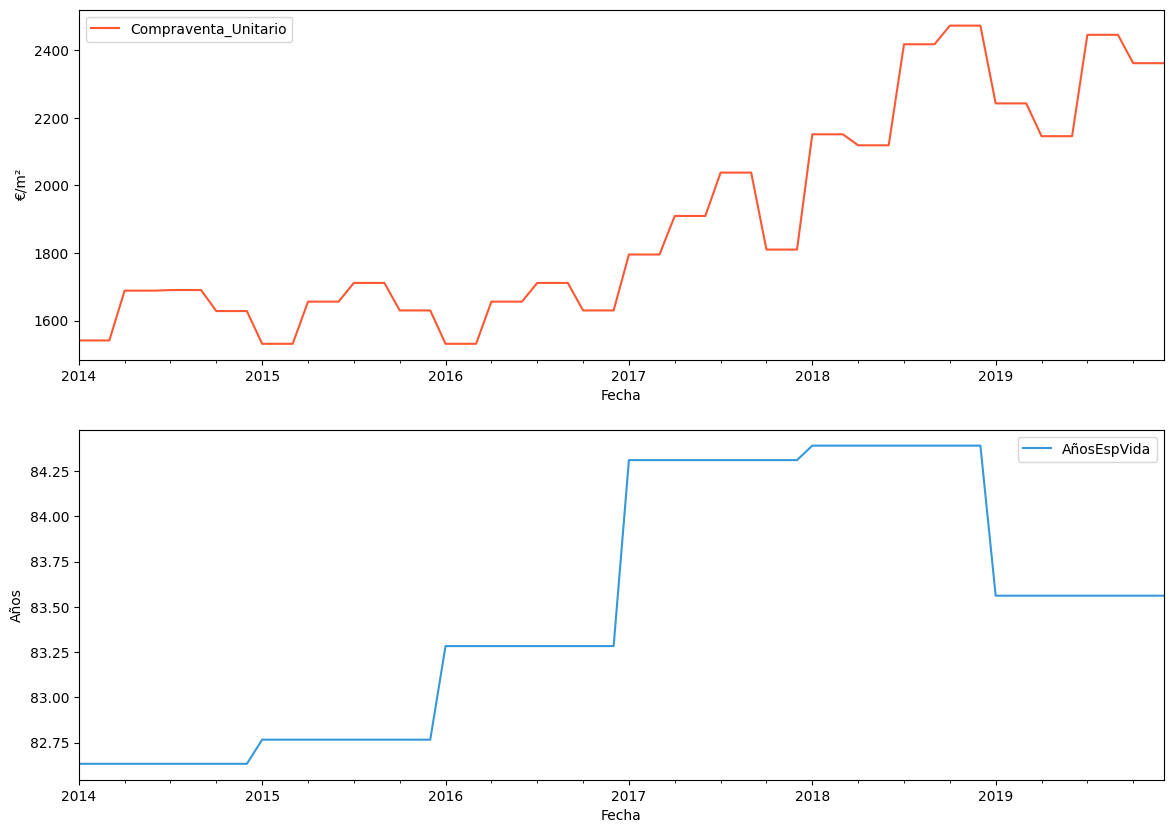

In [14]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', 'Años']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [15]:
corr=df.corr()
corr

,Compraventa_Unitario,AñosEspVida
Compraventa_Unitario,1.000000,0.662267
AñosEspVida,0.662267,1.000000


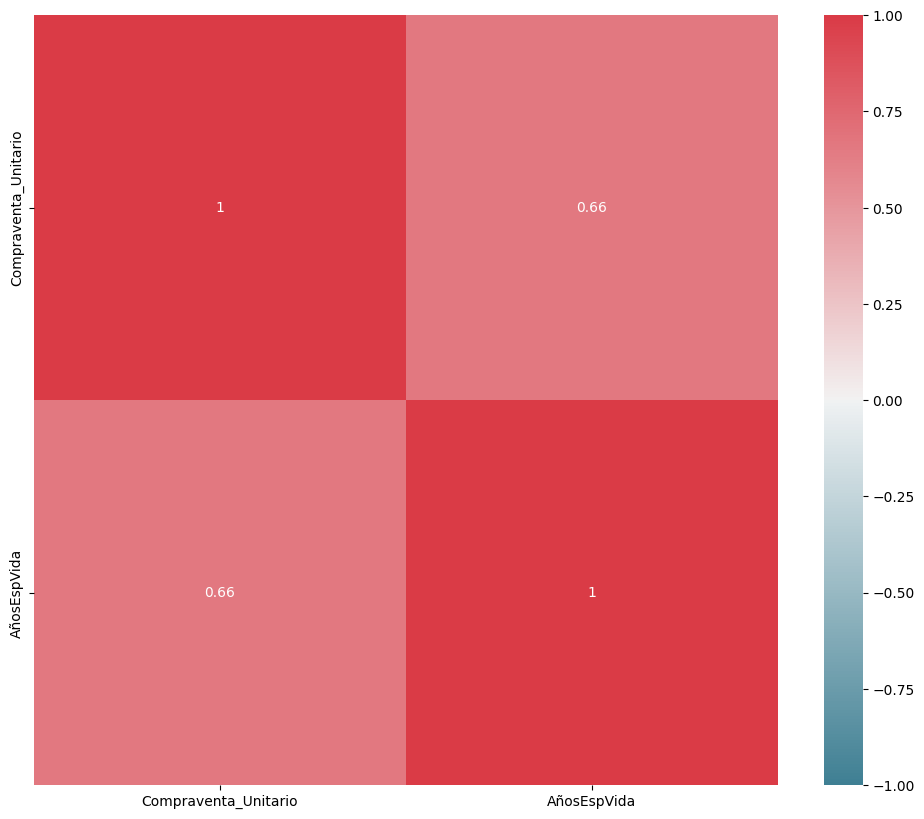

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

Tambien podemos observar como las 2 variables tienen una alta correlacion, concretamente un 66% de correlacion

### Dividir los datos en conjunto de Entrenamiento y Prueba


El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



---



In [17]:
fecha_division = '2019-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)

(60, 2) (12, 2)


####Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [19]:
cointegration_test(X_train[['Compraventa_Unitario', 'AñosEspVida']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  11.35     > 12.3212   =>   False
AñosEspVida >  2.82      > 4.1296    =>   False


* **Compraventa_Unitario**: No hay suficiente evidencia estadística para rechazar la hipótesis nula de no cointegración. Esto sugiere que "Compraventa_Unitario" no tiene una relación de equilibrio estacionario de largo plazo con las otras series en el sistema.
* **AñosEspVida**: Similarmente, "AñosEspVida" tampoco muestra evidencia de cointegración. No existe una combinación lineal estacionaria que vincule esta serie con otras en el sistema a largo plazo.

Para un análisis conjunto que aún considera las interacciones entre múltiples series no cointegradas, usaremos un modelo VAR (Vector Autoregressive) o VARMA (Vector Autoregressive Moving Average) y descartaremos el modelo VECM (Vector Error Correlation Model), pero primero transformaremos comprobaremos y transformaremos por diferenciacion las veces necesrarias para convertir las series en estacionarias

### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [20]:
import statsmodels.tsa.stattools as sts

In [21]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 1.000000
Serie de tiempo AñosEspVida
p-value: 0.851213


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [22]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,AñosEspVida
Fecha,,
2014-02-01,0.000,0.0
2014-03-01,0.000,0.0
2014-04-01,147.275,0.0
2014-05-01,0.000,0.0
2014-06-01,0.000,0.0


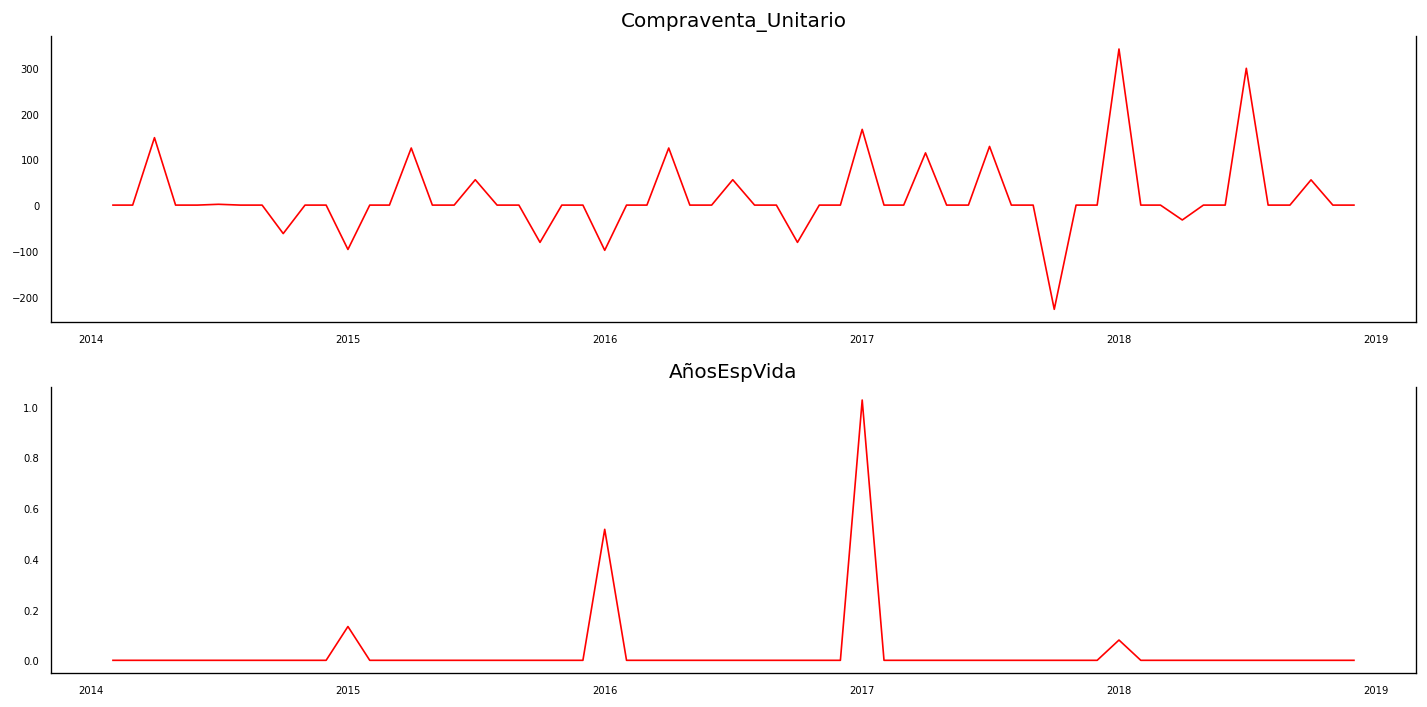

In [23]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [24]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.982824
Serie de tiempo transformada Variable AñosEspVida
p-value: 0.000000


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos por segunda vez porque no se puede confirmar estacionariedad.

In [25]:
#Diferenciando por segunda vez
X_train_transformed=X_train.diff().diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,AñosEspVida
Fecha,,
2014-03-01,0.000000,0.0
2014-04-01,147.275000,0.0
2014-05-01,-147.275000,0.0
2014-06-01,0.000000,0.0
2014-07-01,1.783333,0.0


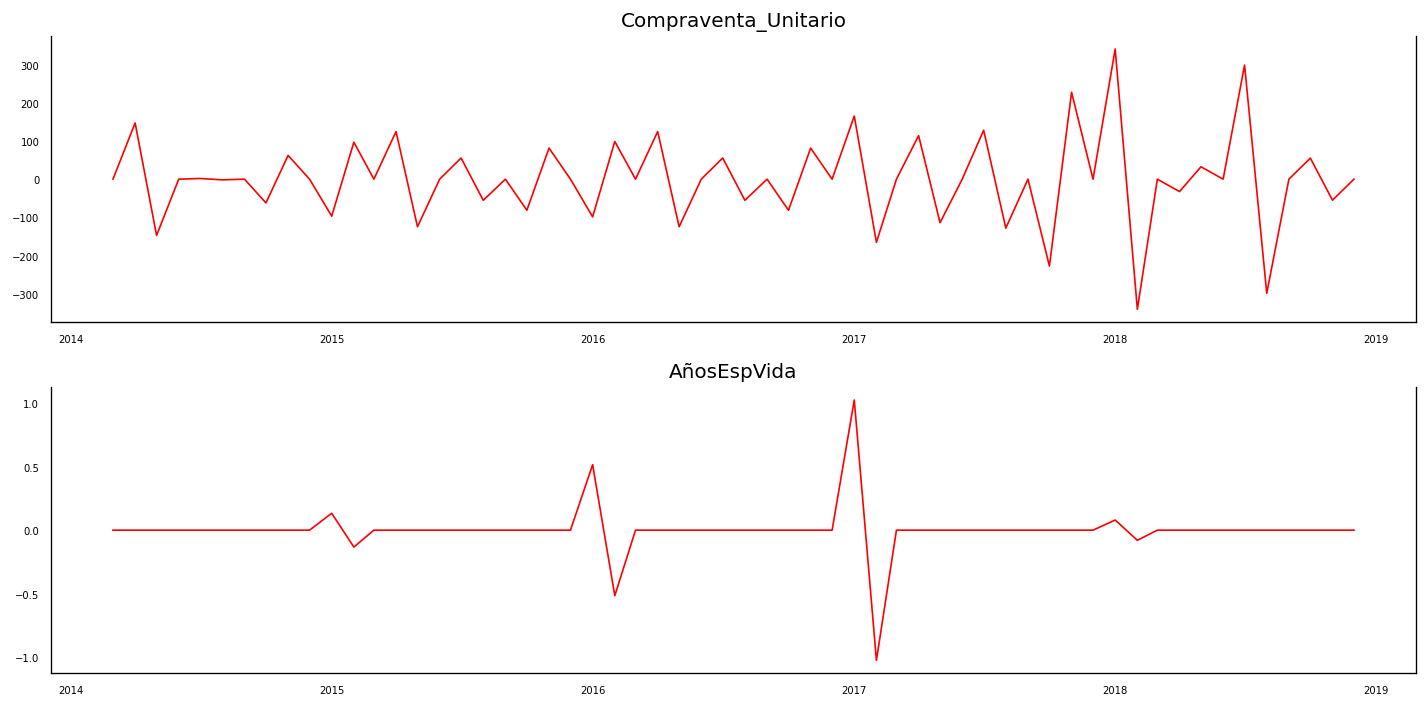

In [26]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [27]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable AñosEspVida
p-value: 0.000005


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 2 ordenes de diferenciación se obtienen series estacionarias.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




In [28]:
from statsmodels.tsa.api import VAR

In [29]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

Se establece un valor de 12 como número óptimo de rezagos, teniendo encuenta, que los datos de las dos series temporales parecen tener un ciclo anual es decir 12 meses

In [33]:
modelsel=model.select_order(12)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,6.899,6.979,991.3,6.929
1,6.505,6.744*,668.8,6.594
2,6.483,6.881,655.3,6.632
3,6.396,6.953,602.4,6.605
4,6.439,7.154,632.1,6.707
5,6.312,7.186,561.5,6.639
6,6.404,7.437,623.5,6.791
7,6.527,7.719,717.8,6.973
8,5.876,7.227,383.4,6.382
9,6.037,7.548,465.0,6.603


El análisis de orden VAR resalta que el modelo con un orden de 11 es el más adecuado, ya que tiene el menor AIC, FPE y HQIC

#### Ajustando el modelo

In [34]:
res = model.fit(maxlags=11)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, May, 2024
Time:                     11:52:32
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    6.93124
Nobs:                     47.0000    HQIC:                   5.80187
Log likelihood:          -207.711    FPE:                    201.119
AIC:                      5.12046    Det(Omega_mle):         90.6676
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           12.735447         8.121993            1.568           0.117
L1.Compraventa_Unitario         -1.036317         0.125666           -8.247           0.000
L

La correlación entre los residuos de "Compraventa_Unitario" y "AñosEspVida" es bastante baja, con un valor de 0.036416. Esto sugiere una correlación muy débil entre los residuos de estas dos variables en tu modelo.

In [35]:
res.is_stable()

False

El modelo no es estable, asi que deberemos revisar la especificacion del modelo. En este caso modificaremos el parametro de maxlags por 1, ya que es el otro periodo que recomendaba el selec order

In [38]:
res = model.fit(maxlags=1)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, May, 2024
Time:                     11:56:05
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    6.34609
Nobs:                     57.0000    HQIC:                   6.21461
Log likelihood:          -330.493    FPE:                    460.001
AIC:                      6.13103    Det(Omega_mle):         415.151
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           0.000000        14.189550            0.000           1.000
L1.Compraventa_Unitario        -0.500000         0.119777           -4.174           0.000
L1.Añ

In [39]:
res.is_stable()

True

In [40]:
X_train.columns

Index(['Compraventa_Unitario', 'AñosEspVida'], dtype='object')

###### Causalidad de Granger

In [41]:
grangercaus=res.test_causality(['AñosEspVida'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
6.262e-32,3.929,1.000,"(1, 108)"


In [42]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['AñosEspVida'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.760e-32,3.929,1.000,"(1, 108)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede causar la otra serie temporal

###### Matriz de causalidad de Granger


In [43]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=1
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,AñosEspVida_x
Compraventa_Unitario_y,1.0,1.0
AñosEspVida_y,1.0,1.0


Como se puede ver en la matriz de causalidad de Granger, podemos considerar que la serie de Compraventa_Unitario causa cambios en la serie de AñosEspVida y viceversa.

###### Diagnosis del modelo


###### Residuos

In [44]:
residuals=res.resid

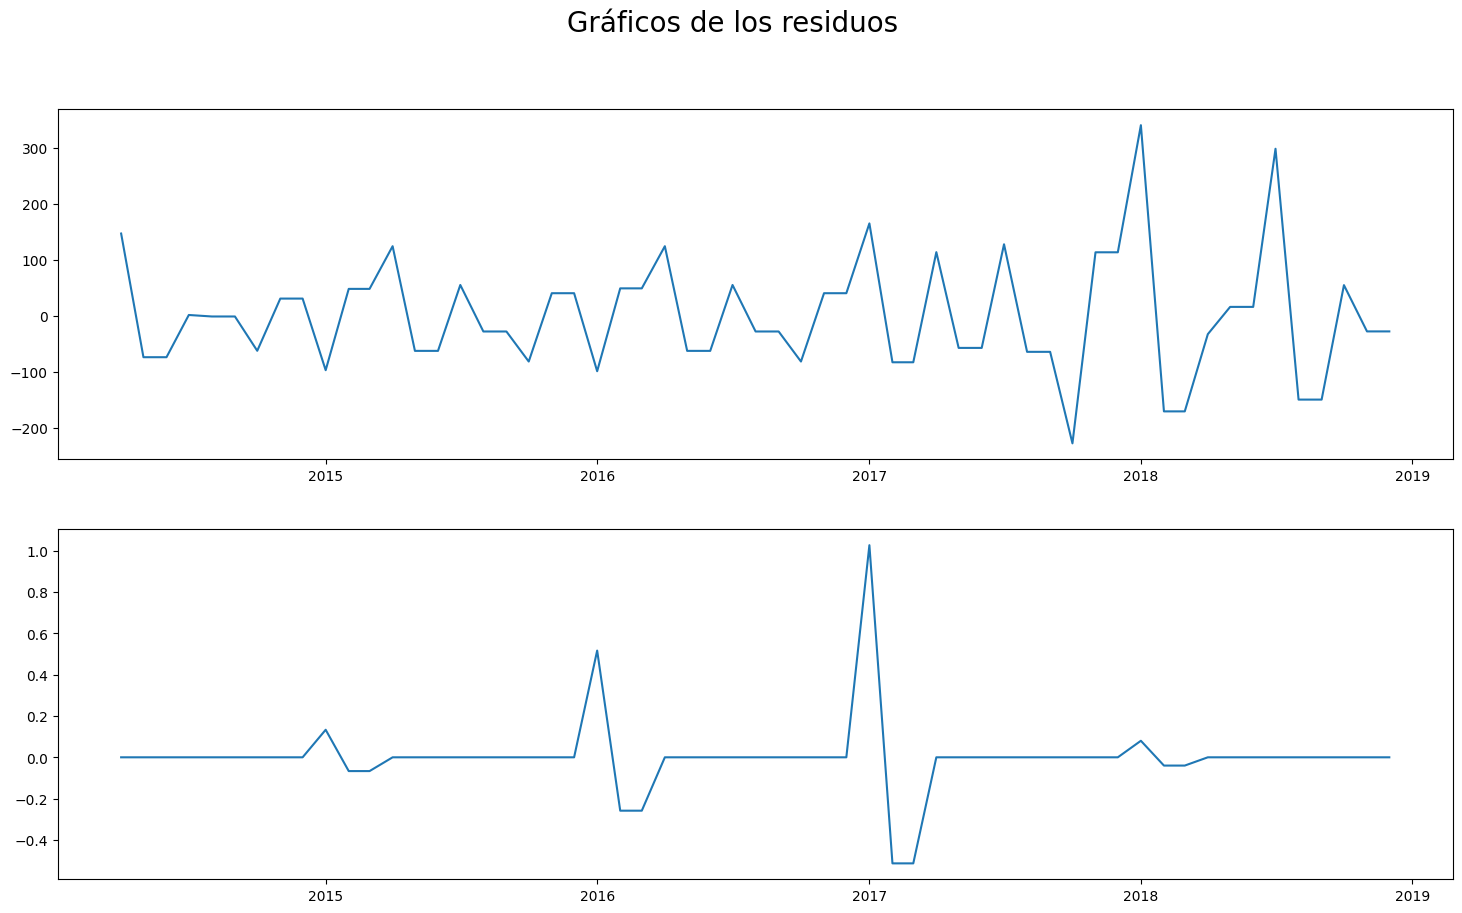

In [45]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [46]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[0.023620141638410412, 6.947491752634538e-06]

Todos los p-valores son < 0.05 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


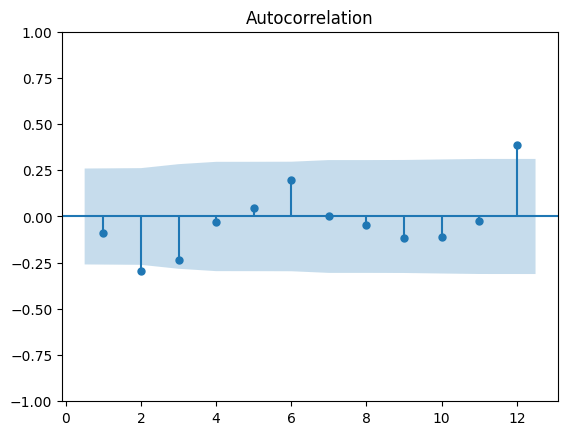

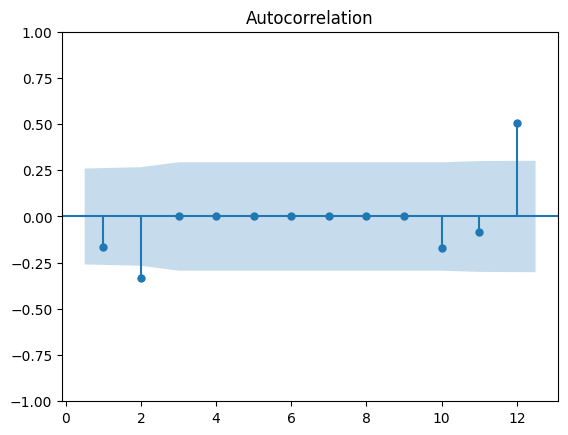

In [47]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Se observa que casi todos los puntos están dentro del intervalo de confianza hasta el rezago 11, lo que sugiere que no hay autocorrelaciones significativas para esos rezagos. Esto es un buen indicio y sugiere que el modelo está adecuadamente especificado para estos rezagos.

El punto en el rezago 2 que sale del intervalo de confianza indica una autocorrelación significativa. Este es un hallazgo importante que puede sugerir varias cosas:

Subespecificación del Modelo: Es posible que el modelo necesite más rezagos para capturar adecuadamente la dinámica subyacente de las series temporales, especialmente si hay una periodicidad o estacionalidad no capturada por el modelo actual.
Estructura Estacional: Si el modelo no incluyó términos para manejar la estacionalidad y los datos son estacionales (como datos mensuales con patrones anuales), esto podría explicar por qué se detecta autocorrelación a este rezago.



In [48]:
res = model.fit(2)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, May, 2024
Time:                     11:58:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    6.43268
Nobs:                     56.0000    HQIC:                   6.21122
Log likelihood:          -318.909    FPE:                    433.529
AIC:                      6.07101    Det(Omega_mle):         365.372
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -2.491220        13.900002           -0.179           0.858
L1.Compraventa_Unitario        -0.570465         0.134371           -4.245           0.000
L1.Añ

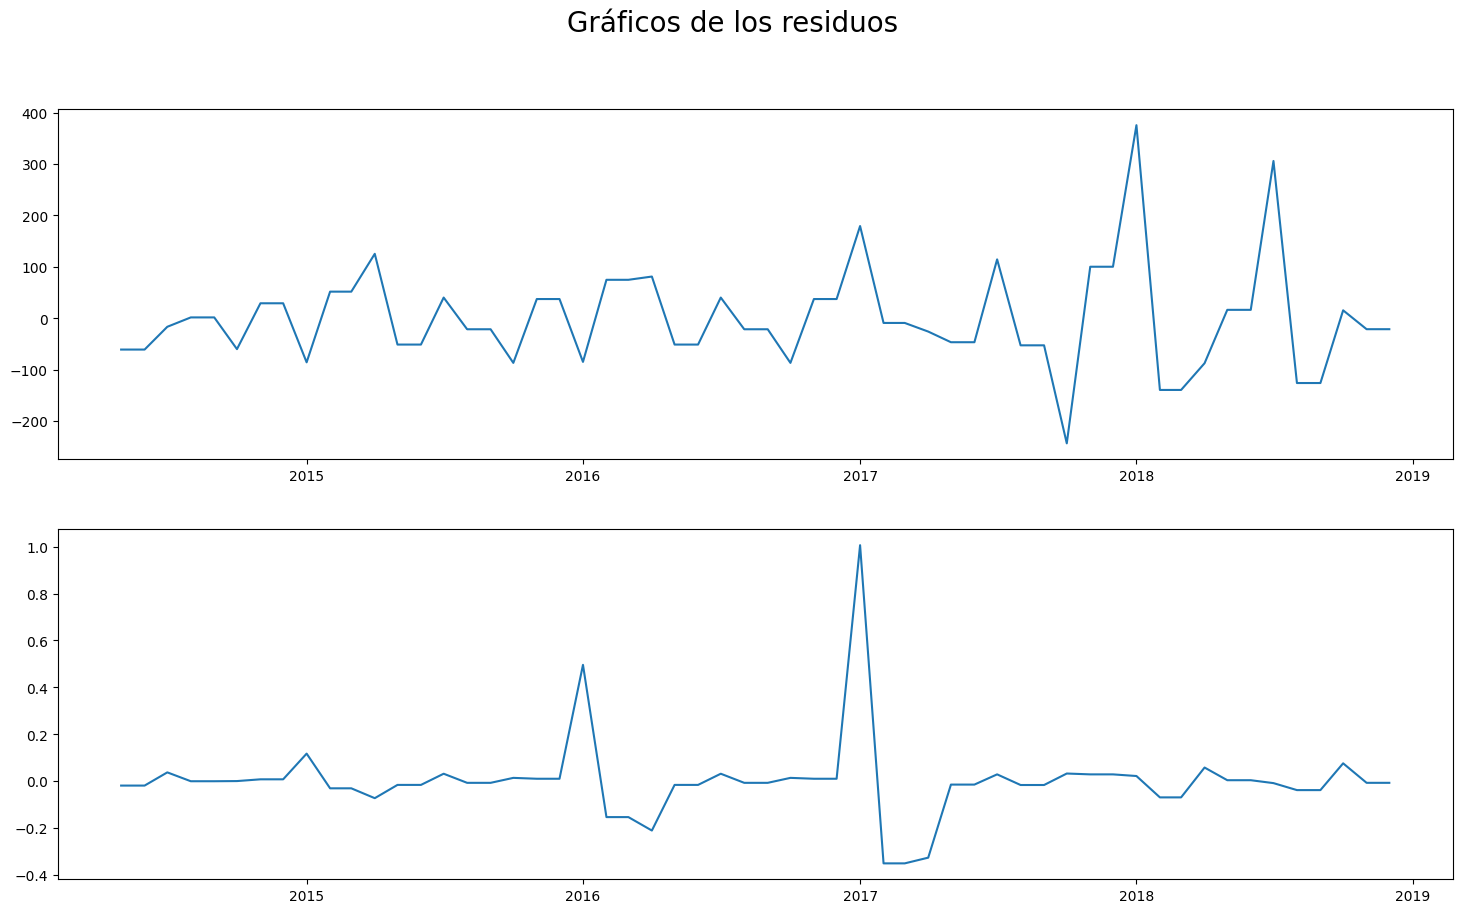

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Graficar la autocorrelación de los residuos del nuevo modelo
resid = res.resid
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(resid.iloc[:,i]) for i in range(2)]
plt.show()

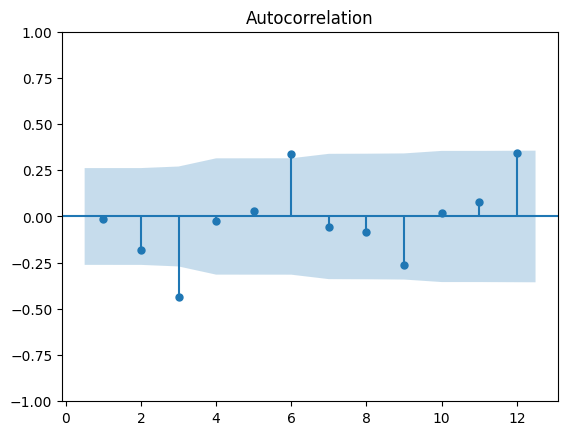

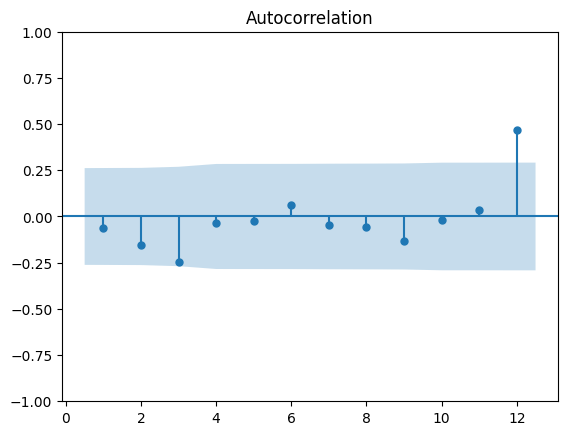

In [50]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(resid.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Se observa que casi todos los puntos están dentro del intervalo de confianza hasta el rezago 11, lo que sugiere que no hay autocorrelaciones significativas para esos rezagos. Esto es un buen indicio y sugiere que el modelo está adecuadamente especificado para estos rezagos.

El punto en el rezago 3 que sale del intervalo de confianza indica una autocorrelación significativa. Este es un hallazgo importante que puede sugerir varias cosas:

Subespecificación del Modelo: Es posible que el modelo necesite más rezagos para capturar adecuadamente la dinámica subyacente de las series temporales, especialmente si hay una periodicidad o estacionalidad no capturada por el modelo actual.
Estructura Estacional: Si el modelo no incluyó términos para manejar la estacionalidad y los datos son estacionales (como datos mensuales con patrones anuales), esto podría explicar por qué se detecta autocorrelación a este rezago.

In [51]:
res = model.fit(3)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, May, 2024
Time:                     12:00:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    6.51824
Nobs:                     55.0000    HQIC:                   6.20488
Log likelihood:          -307.284    FPE:                    407.508
AIC:                      6.00729    Det(Omega_mle):         320.685
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -1.255450        13.230366           -0.095           0.924
L1.Compraventa_Unitario        -0.596067         0.133349           -4.470           0.000
L1.Añ

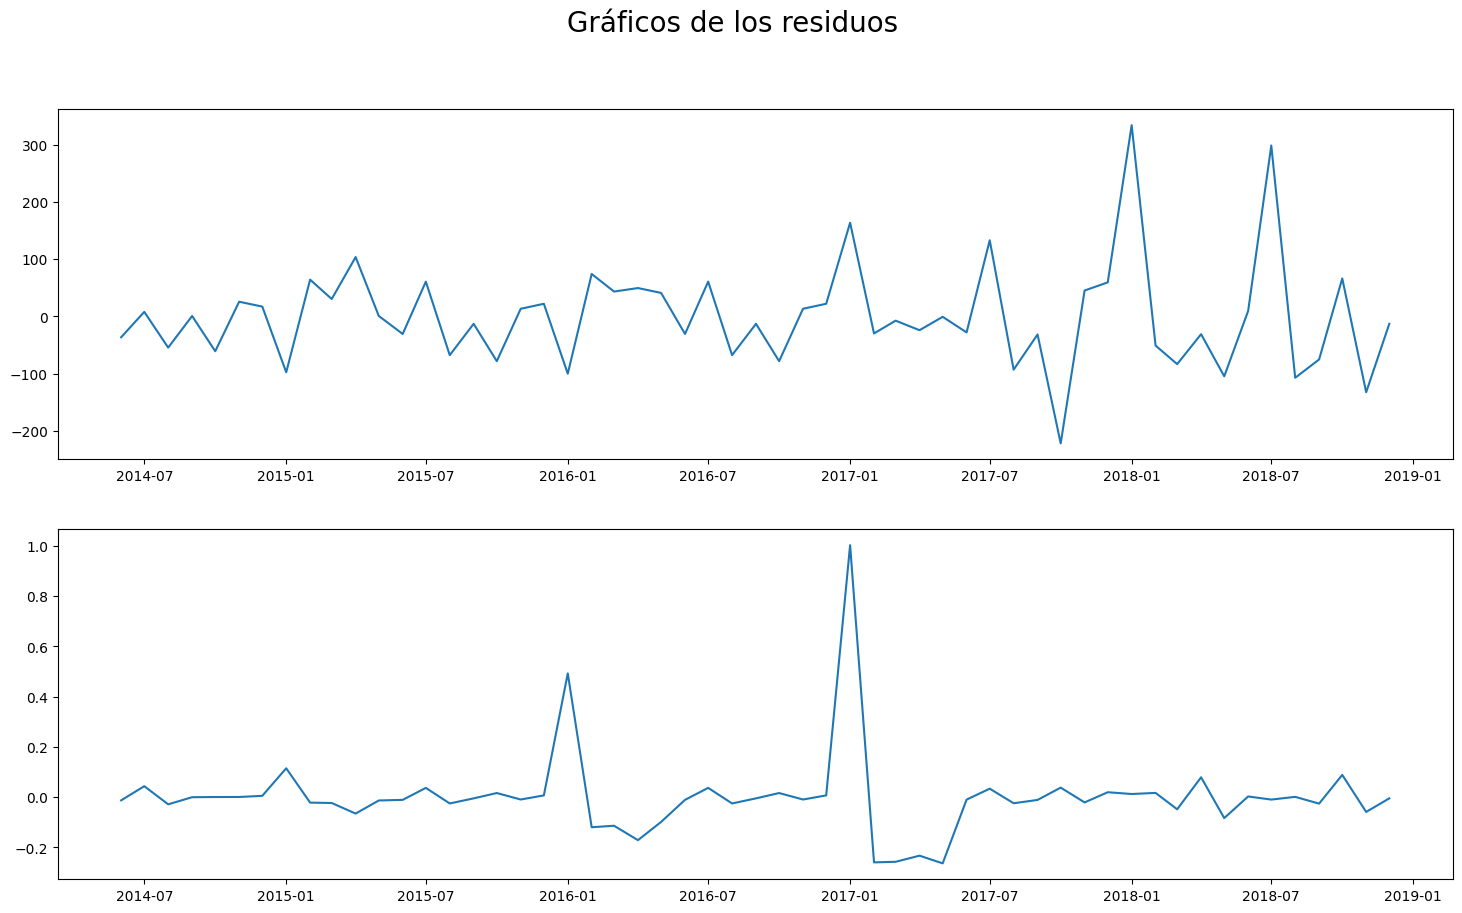

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Graficar la autocorrelación de los residuos del nuevo modelo
resid = res.resid
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(resid.iloc[:,i]) for i in range(2)]
plt.show()

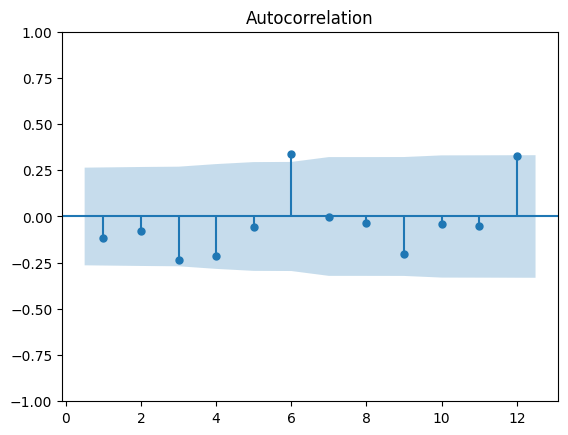

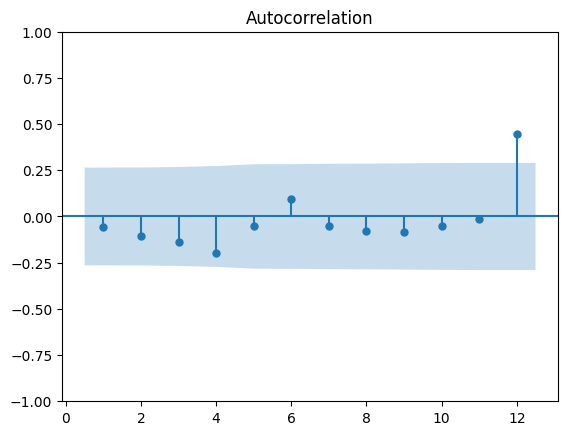

In [54]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(resid.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Se observa que casi todos los puntos están dentro del intervalo de confianza hasta el rezago 11, lo que sugiere que no hay autocorrelaciones significativas para esos rezagos. Esto es un buen indicio y sugiere que el modelo está adecuadamente especificado para estos rezagos.

El punto en el rezago 6 que sale del intervalo de confianza indica una autocorrelación significativa. Este es un hallazgo importante que puede sugerir varias cosas:

Subespecificación del Modelo: Es posible que el modelo necesite más rezagos para capturar adecuadamente la dinámica subyacente de las series temporales, especialmente si hay una periodicidad o estacionalidad no capturada por el modelo actual.
Estructura Estacional: Si el modelo no incluyó términos para manejar la estacionalidad y los datos son estacionales (como datos mensuales con patrones anuales), esto podría explicar por qué se detecta autocorrelación a este rezago.

In [55]:
res = model.fit(6)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, May, 2024
Time:                     12:01:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.10947
Nobs:                     52.0000    HQIC:                   6.50788
Log likelihood:          -281.050    FPE:                    471.302
AIC:                      6.13385    Det(Omega_mle):         301.633
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           1.723199        12.645865            0.136           0.892
L1.Compraventa_Unitario        -0.801282         0.156767           -5.111           0.000
L1.Añ

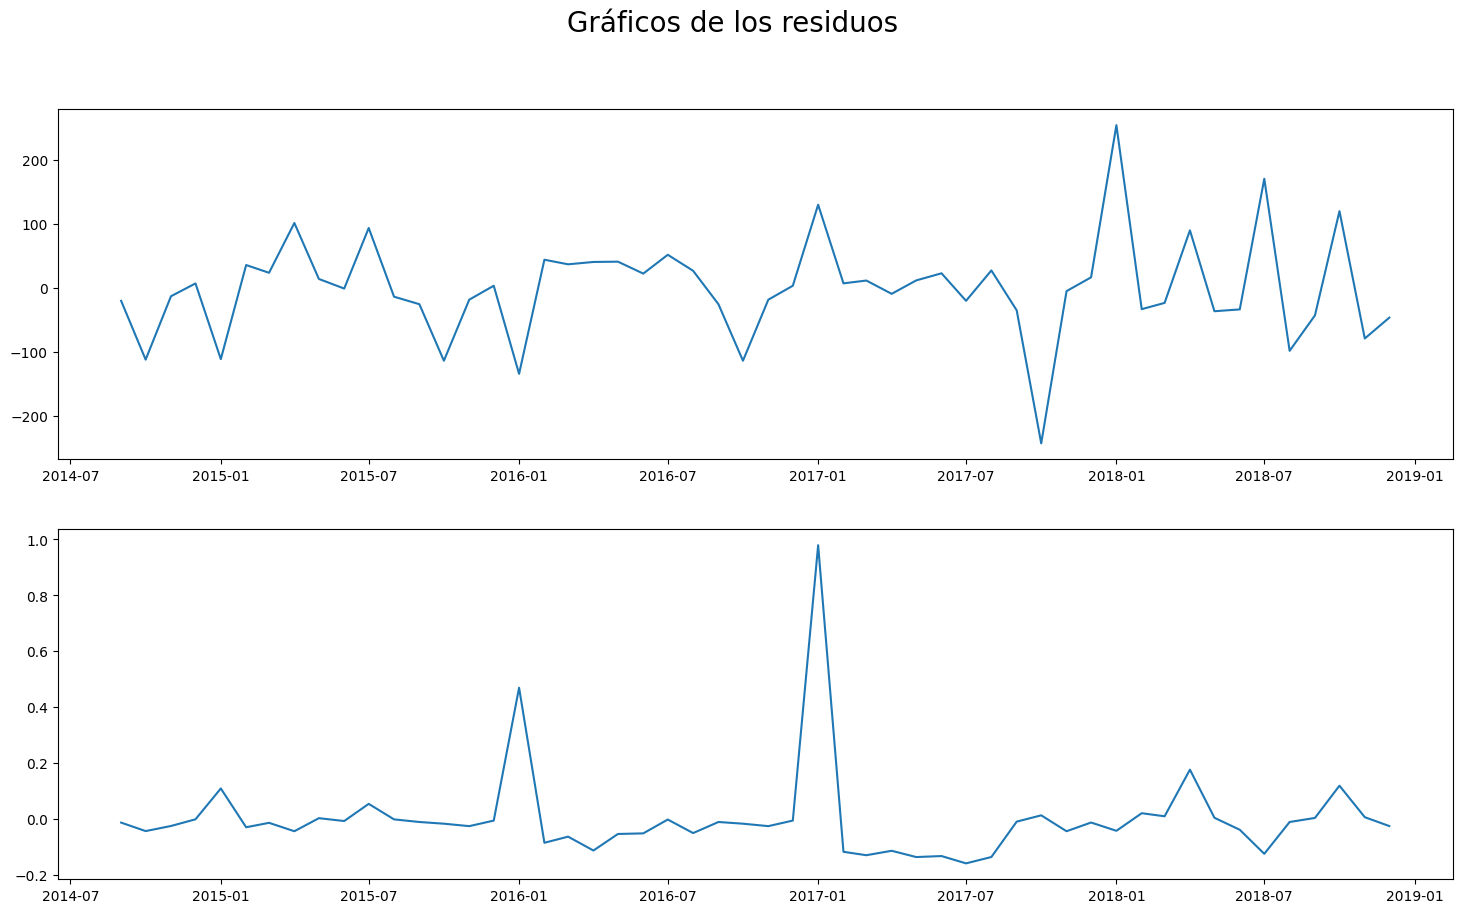

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Graficar la autocorrelación de los residuos del nuevo modelo
resid = res.resid
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(resid.iloc[:,i]) for i in range(2)]
plt.show()

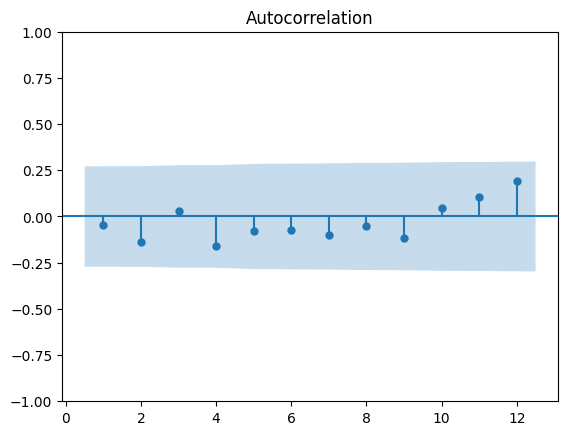

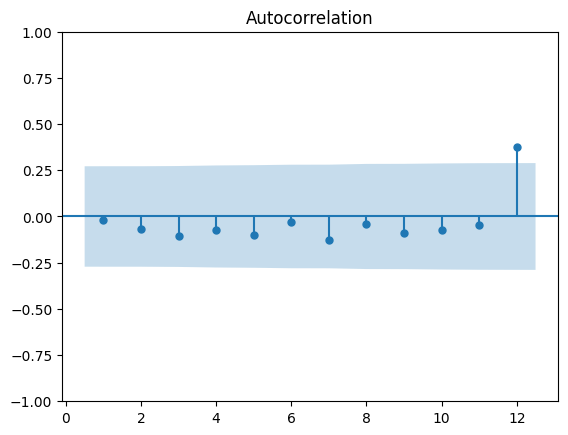

In [57]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(resid.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Se observa que casi todos los puntos están dentro del intervalo de confianza hasta el rezago 11, lo que sugiere que no hay autocorrelaciones significativas para esos rezagos. Esto es un buen indicio y sugiere que el modelo está adecuadamente especificado para estos rezagos.

El punto en el rezago 12 que sale del intervalo de confianza indica una autocorrelación significativa. Este es un hallazgo importante que puede sugerir varias cosas:

Subespecificación del Modelo: Es posible que el modelo necesite más rezagos para capturar adecuadamente la dinámica subyacente de las series temporales, especialmente si hay una periodicidad o estacionalidad no capturada por el modelo actual.
Estructura Estacional: Si el modelo no incluyó términos para manejar la estacionalidad y los datos son estacionales (como datos mensuales con patrones anuales), esto podría explicar por qué se detecta autocorrelación a este rezago.

In [59]:
res = model.fit(12)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, May, 2024
Time:                     12:02:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.33452
Nobs:                     46.0000    HQIC:                   6.09146
Log likelihood:          -203.520    FPE:                    272.945
AIC:                      5.34687    Det(Omega_mle):         114.571
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           12.927357         9.159560            1.411           0.158
L1.Compraventa_Unitario         -1.037233         0.217741           -4.764           0.000
L

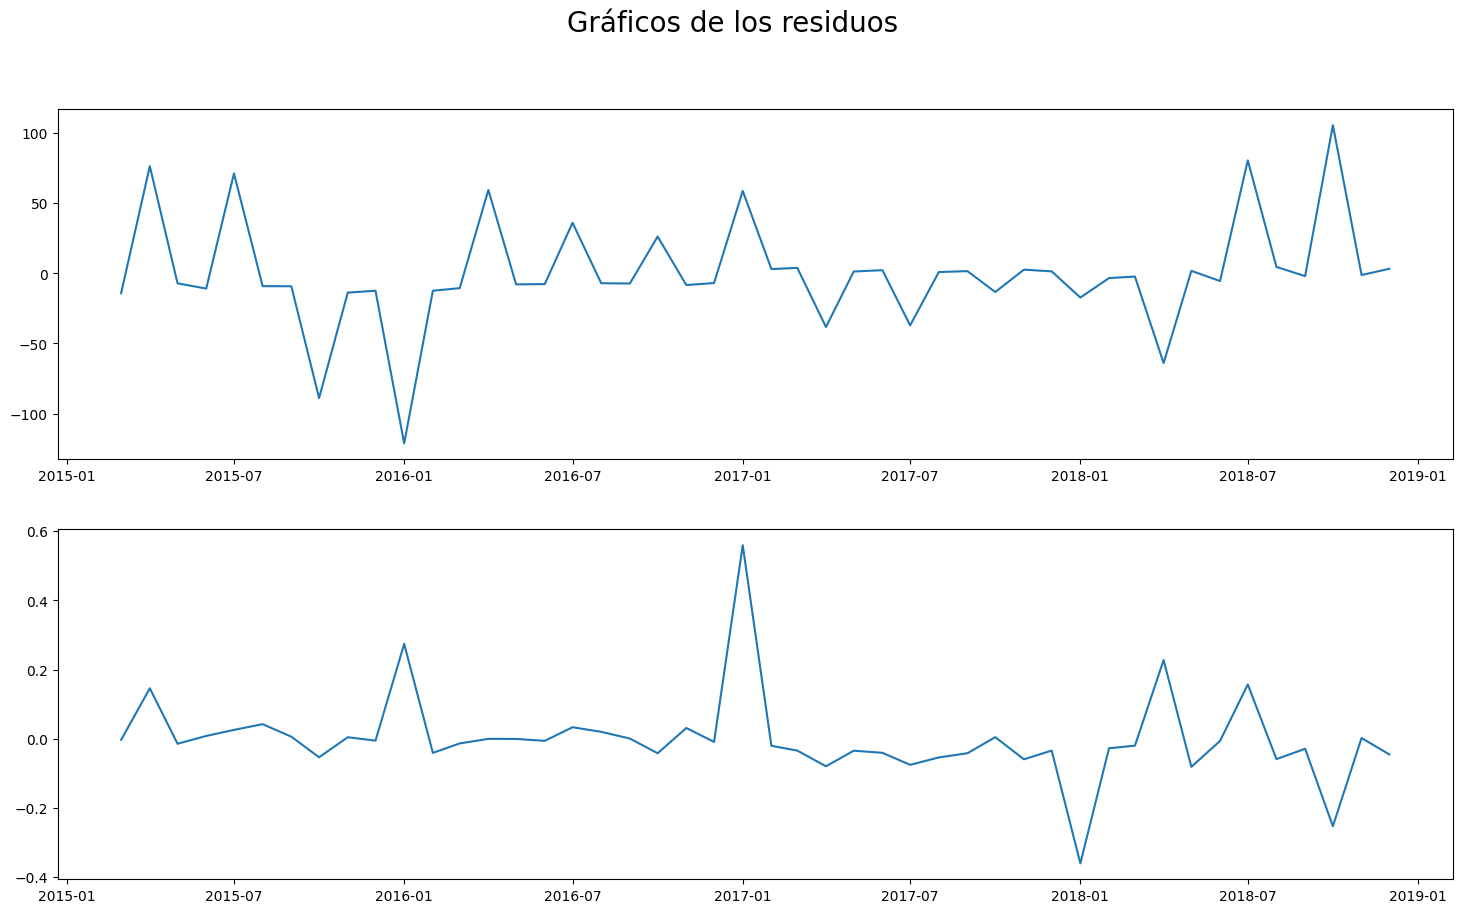

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Graficar la autocorrelación de los residuos del nuevo modelo
resid = res.resid
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(resid.iloc[:,i]) for i in range(2)]
plt.show()

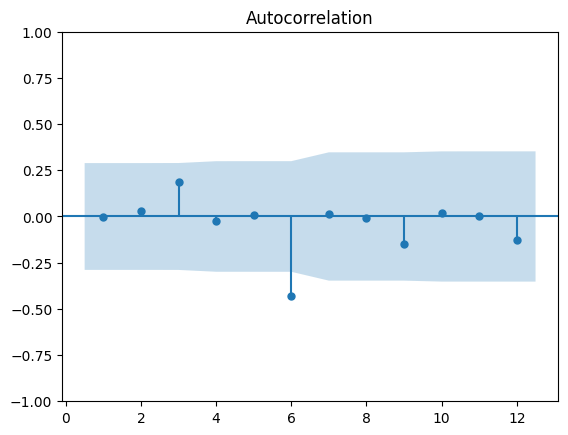

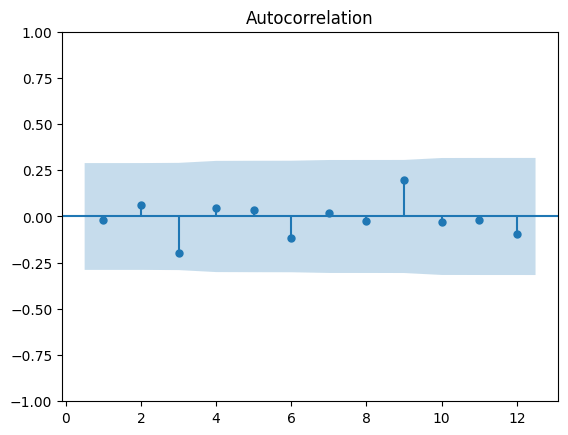

In [62]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(resid.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Como se puede observar, los puntos de rezado varian entre 6 y 12.
Visualmente nos parece que los datos tienen ciclos anuales, por lo que se estima 6

In [72]:
res = model.fit(6)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, May, 2024
Time:                     12:07:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.10947
Nobs:                     52.0000    HQIC:                   6.50788
Log likelihood:          -281.050    FPE:                    471.302
AIC:                      6.13385    Det(Omega_mle):         301.633
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           1.723199        12.645865            0.136           0.892
L1.Compraventa_Unitario        -0.801282         0.156767           -5.111           0.000
L1.Añ

#### Valores predichos


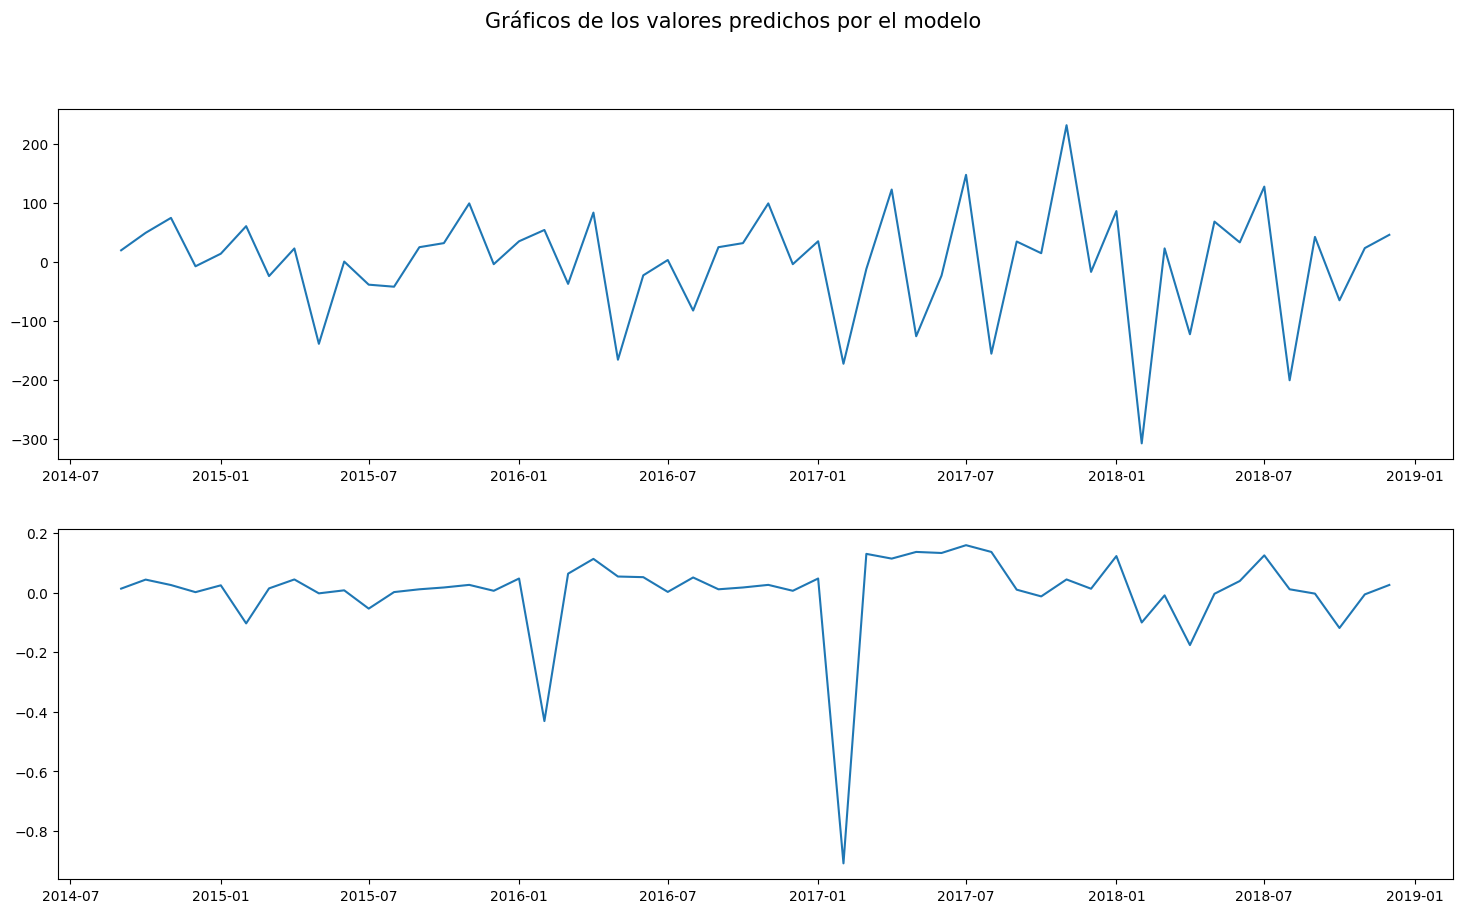

In [73]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [74]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=12)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 6
Predicciones:


,Compraventa_Unitario_pred,AñosEspVida_pred
Fecha,,
2019-01-01,88.818520,0.068555
2019-02-01,-12.094496,-0.035802
2019-03-01,-42.709437,-0.023940
2019-04-01,-2.019810,-0.010327
2019-05-01,-2.316648,-0.004941
2019-06-01,0.910488,0.012998
2019-07-01,26.750512,0.026573
2019-08-01,-1.018570,0.003616
2019-09-01,-9.531835,-0.018032


<Figure size 1200x1000 with 0 Axes>

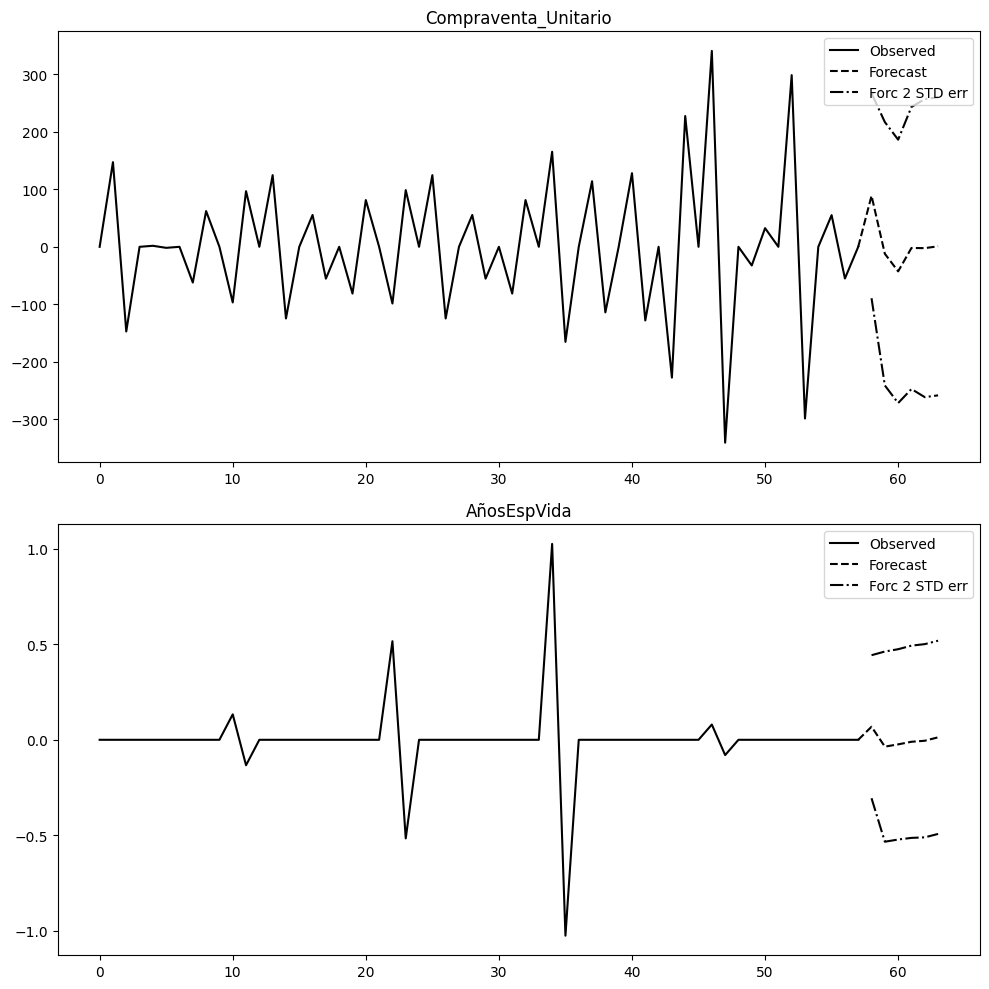

In [75]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [76]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [77]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=True)
output

,Compraventa_Unitario,AñosEspVida
Fecha,,
2019-01-01,2561.208520,84.458555
2019-02-01,2637.932545,84.491307
2019-03-01,2671.947132,84.500120
2019-04-01,2703.941909,84.498605
2019-05-01,2733.620039,84.492150
2019-06-01,2764.208656,84.498693
2019-07-01,2821.547785,84.531808
2019-08-01,2877.868344,84.568540
2019-09-01,2924.657068,84.587239


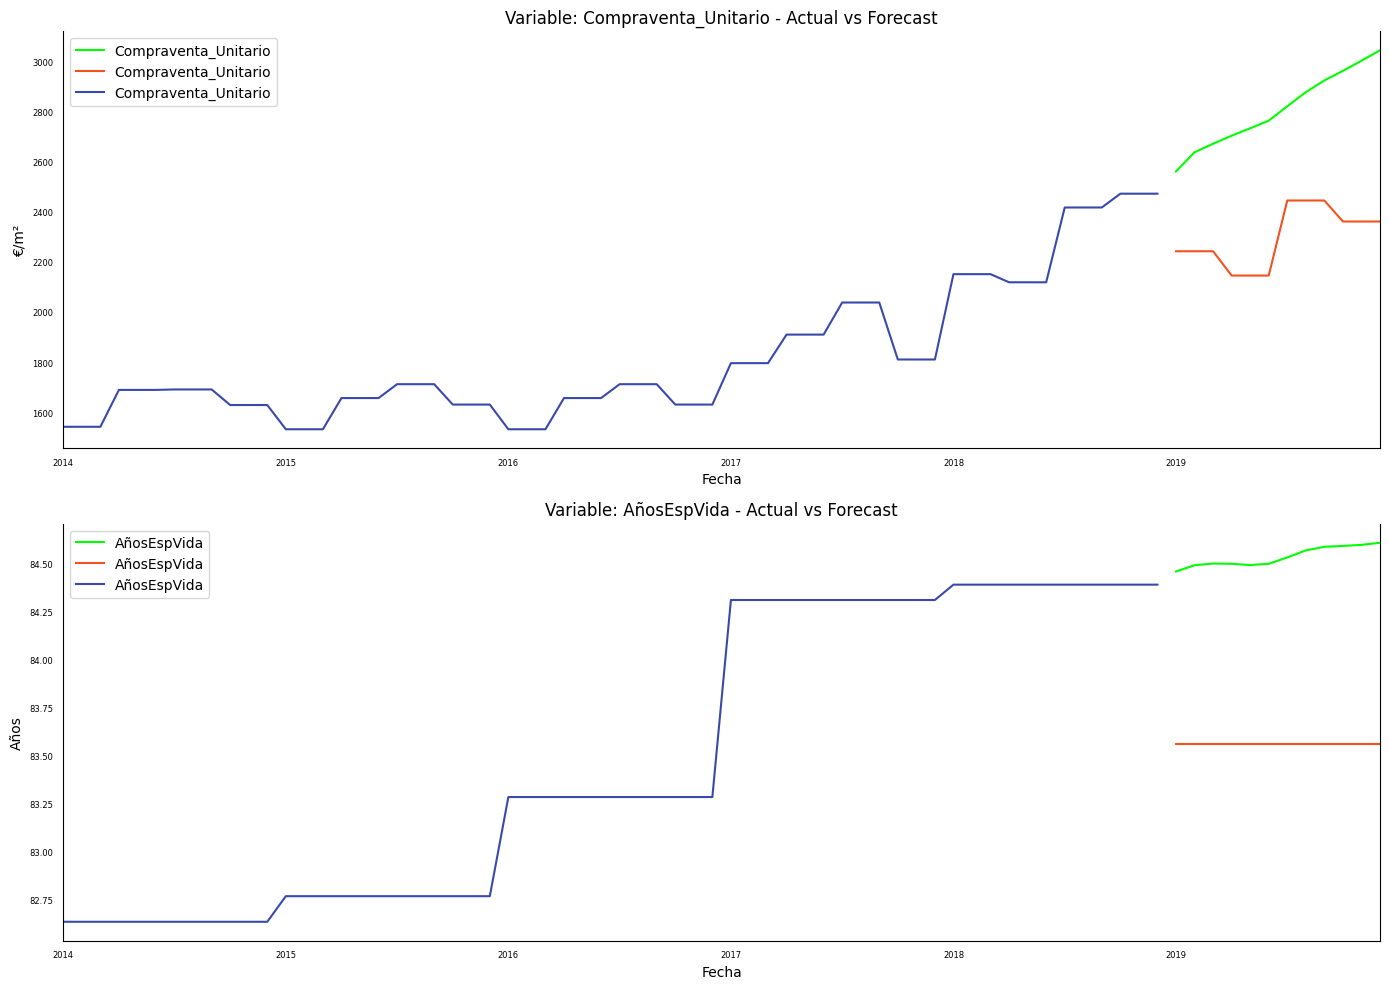

In [78]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'Años']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [79]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [80]:
for i in ['Compraventa_Unitario','AñosEspVida']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 273620.3749856815
MAE is : 510.40696389484657
RMSE is : 523.0873492885117
MAPE is : 22.299897979197354
R2 is : -20.037415332805438

Evaluation metric for AñosEspVida
Evaluation metric results:-
MSE is : 0.9508279764502174
MAE is : 0.9738303252617394
RMSE is : 0.9751040849315613
MAPE is : 1.1654049736171048
R2 is : 0.0



Los resultados para Compraventa_Unitario muestran una falta de adecuación significativa en el modelo, con un R² de -20.04, indicando que el modelo es peor que un simple promedio. Los valores altos en MSE, MAE, y RMSE reflejan grandes errores en las predicciones, y un MAPE del 22.30% también sugiere una baja precisión relativa.

En cuanto a AñosEspVida, los errores cuantitativos MSE, MAE y RMSE son relativamente bajos, pero un R² de 0.0 indica que el modelo no mejora las predicciones más allá de un modelo basado en la media. El MAPE de 1.17% muestra una precisión relativamente buena, aunque el modelo no captura la variabilidad de los datos.

In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 255.69039711005416
Root mean squared error: 369.8792544964221


### Modelo VARMA (Auto Arima)

El modelo VARMA (Vector Autoregressive Moving Average) es una técnica estadística utilizada en análisis de series temporales que combina los modelos VAR (Vector Autoregressive) y MA (Moving Average). Es especialmente útil cuando se trata de series temporales múltiples, permitiendo modelar la interdependencia entre varias series a lo largo del tiempo junto con términos de error autocorrelacionados.



In [82]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.3 MB/s eta 0:00:00


#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [83]:
import pmdarima as pm

In [85]:
pq = []
for name in ['Compraventa_Unitario', 'AñosEspVida']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train_transformed[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                  d=0,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=721.325, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=706.922, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=707.049, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=708.922, Time=0.14 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.309 seconds
optimal order for:Compraventa_Unitario is: (1, 0, 0) 


Searching order of p and q for : AñosEspVida
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-11.508, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-25.912, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-30.51

In [86]:
pq

[(1, 0, 0), (4, 0, 0)]

Para la serie temporal de compraventa unitario

- *p=1:* Indica que se incluye un término autoregresivo de primer orden para esta variable en el modelo, es decir, se considera la dependencia de la variable respecto a su propio valor en el periodo anterior.

- *q=0:* Indica que no se incluyen términos de medias móviles para esta variable en el modelo, lo que significa que no se considera la dependencia de los errores pasados de esta variable en sí misma.

Para la serie temporal de años de esperanza de vida

- *p=4:* Indica que se incluyen términos autoregresivos hasta el cuarto orden para esta variable en el modelo, es decir, se considera la dependencia de la variable respecto a sus valores en los cuatro periodos anteriores.

- *q=0: *Indica que no se incluyen términos de medias móviles para esta variable en el modelo, lo que significa que no se considera la dependencia de los errores pasados de esta variable en sí misma.

#####Seleccion del modelo

In [87]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [88]:
model = VARMAX(X_train_transformed[['Compraventa_Unitario','AñosEspVida']], order=(4,0), trend='n').fit(disp=False)

In [90]:
model.summary()

Dep. Variable:,"['Compraventa_Unitario', 'AñosEspVida']",No. Observations:,58
Model:,VAR(4),Log Likelihood,-319.626
Date:,"Wed, 15 May 2024",AIC,677.253
Time:,12:14:02,BIC,716.401
Sample:,03-01-2014,HQIC,692.502
,- 12-01-2018,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.36, 0.16",Jarque-Bera (JB):,"46.83, 1148.08"
Prob(Q):,"0.55, 0.69",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.16, 2.36",Skew:,"1.32, 3.98"
Prob(H) (two-sided):,"0.00, 0.07",Kurtosis:,"6.53, 23.29"


#### Valores predichos

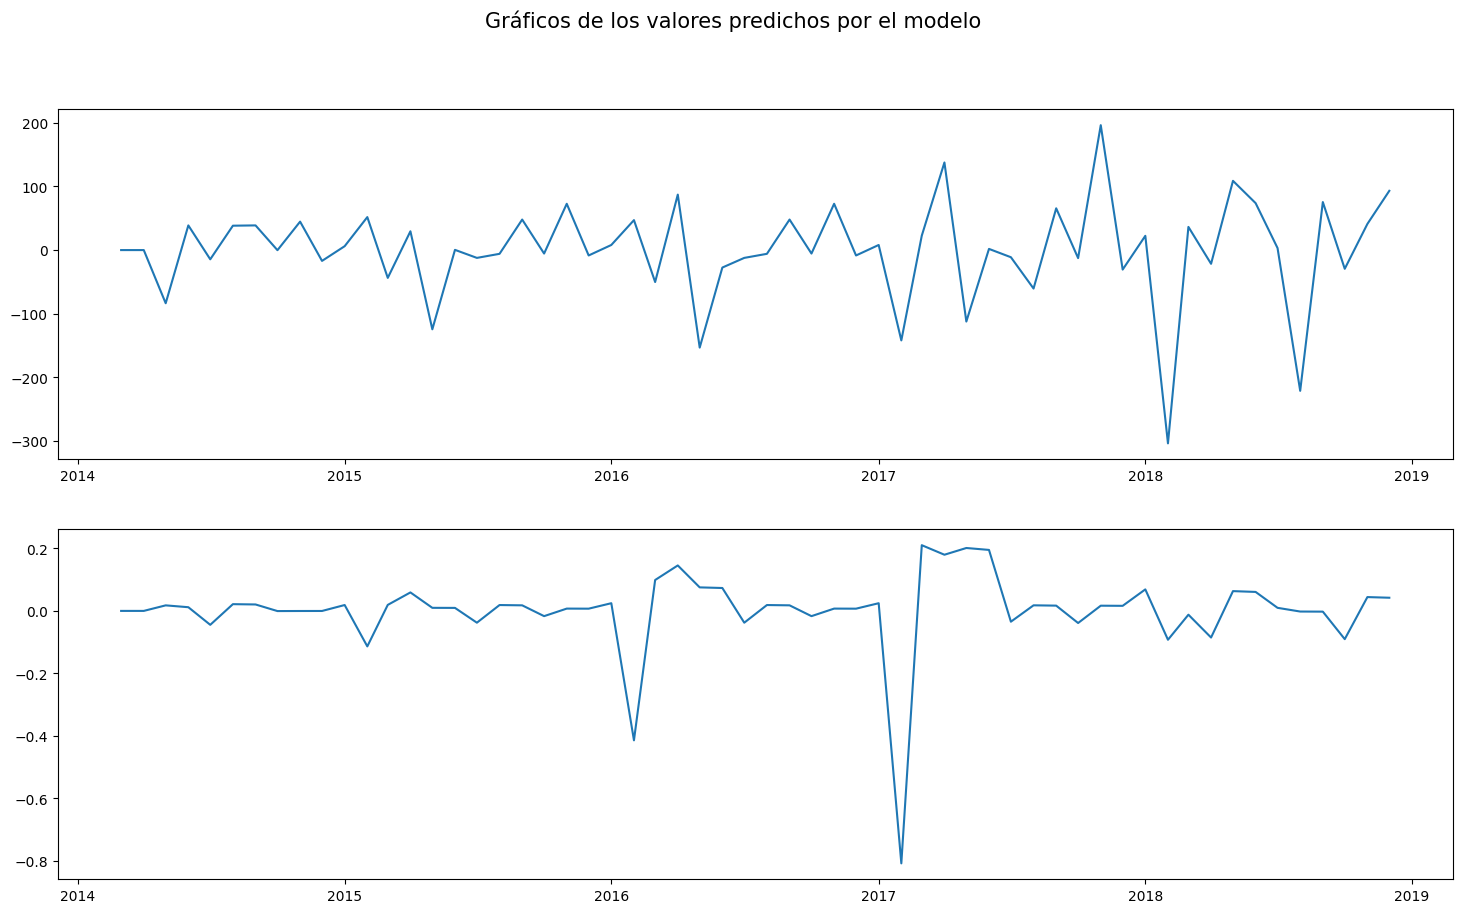

In [91]:
y_fitted = model.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


In [92]:
result = model.forecast(steps = 12)

In [93]:
result

,Compraventa_Unitario,AñosEspVida
2019-01-01,-5.424910,-0.016672
2019-02-01,18.702954,0.020966
2019-03-01,3.388777,0.000867
2019-04-01,-10.108058,-0.004927
2019-05-01,-0.888530,-0.005601
2019-06-01,-0.014213,-0.000427
2019-07-01,4.230503,0.007404
2019-08-01,-1.083767,-0.001090
2019-09-01,-1.305776,-0.002048
2019-10-01,0.215189,-0.001467


#### Invertiendo la transformacion de los pronosticos a la escala original

In [94]:
def inverse_diff(actual_df, pred_df, second_diff=False):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        if second_diff:
          df_res[str(col)] = (actual_df[col].iloc[-1]- actual_df[col].iloc[-2]) + df_res[str(col)].cumsum()

        df_res[str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [95]:
res = inverse_diff(df[['Compraventa_Unitario', 'AñosEspVida']],result,True)

In [96]:
res

,Compraventa_Unitario,AñosEspVida
2019-01-01,2355.905859,83.544866
2019-02-01,2369.183903,83.549160
2019-03-01,2385.850724,83.554320
2019-04-01,2392.409487,83.554554
2019-05-01,2398.079719,83.549187
2019-06-01,2403.735739,83.543393
2019-07-01,2413.622261,83.545003
2019-08-01,2422.425016,83.545523
2019-09-01,2429.921996,83.543995
2019-10-01,2437.634164,83.541000


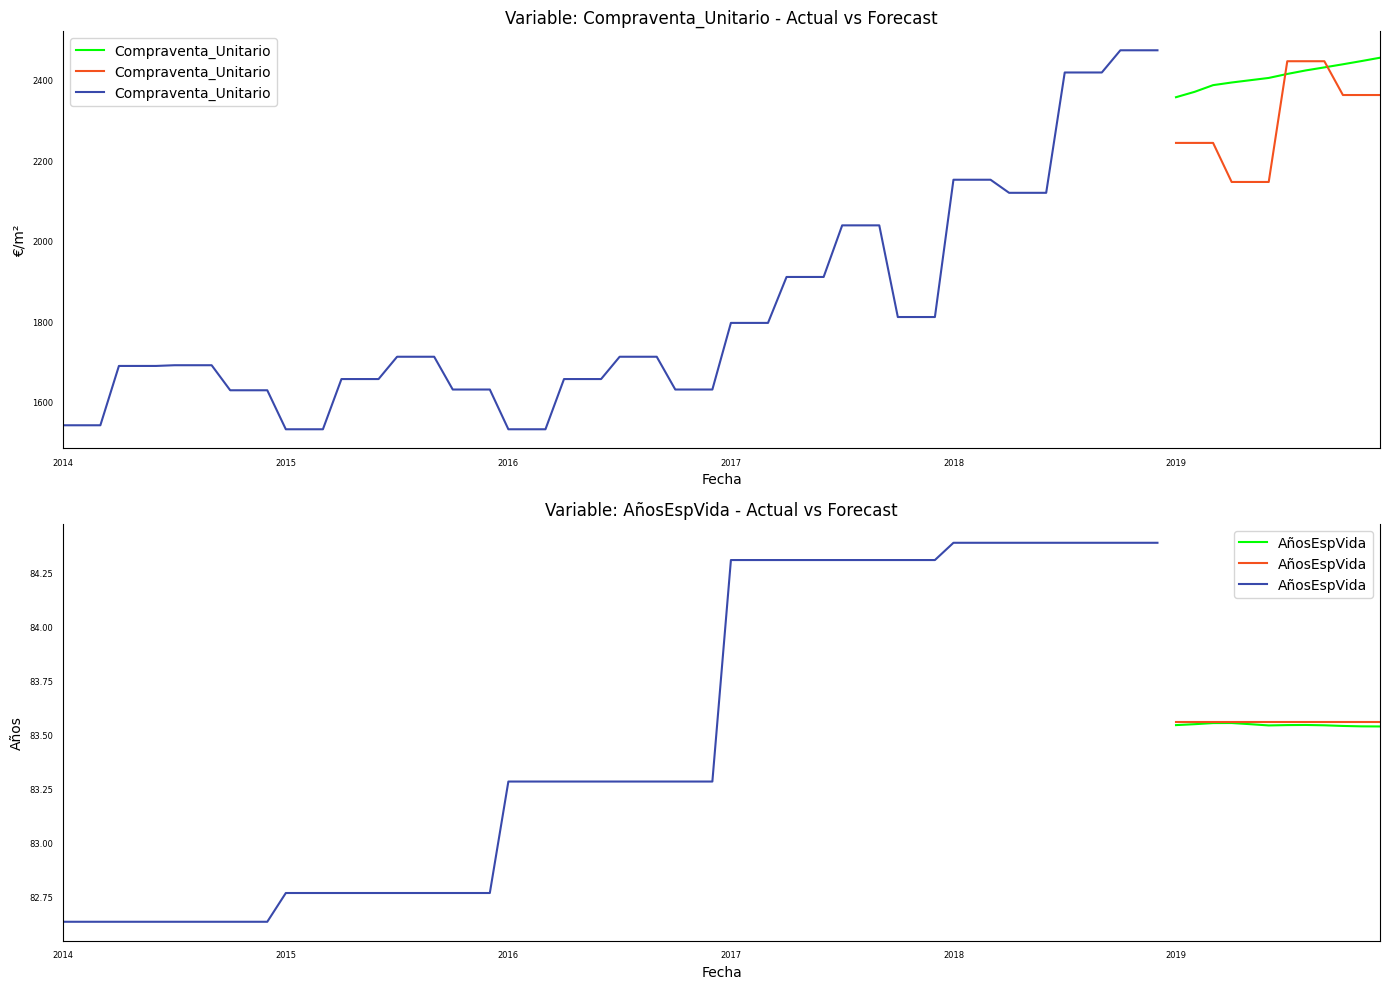

In [97]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'Años']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    res[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo

In [98]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [99]:
for i in ['Compraventa_Unitario','AñosEspVida']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , res[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 22015.82724170253
MAE is : 122.01395403451504
RMSE is : 148.37731377034203
MAPE is : 5.499495102431696
R2 is : -0.6926959536665547

Evaluation metric for AñosEspVida
Evaluation metric results:-
MSE is : 0.0002750944409980059
MAE is : 0.015809772556737062
RMSE is : 0.016585971210574493
MAPE is : 0.018919915606884084
R2 is : 0.0




El modelo para Compraventa_Unitario muestra un desempeño muy deficiente, reflejado por un R² negativo de -0.692, indicando que el modelo es significativamente peor que un modelo básico de la media. Los valores elevados en MSE, MAE, y RMSE también destacan grandes errores en las predicciones, mientras que un MAPE del 5.5% sugiere una precisión razonable en términos porcentuales.

Por otro lado, el modelo para AñosEspVida tiene un rendimiento muy bueno en términos de errores absolutos, con MSE, MAE, y RMSE extremadamente bajos, y un MAPE del 0.019% que indica alta precisión en la predicción. Sin embargo, un R² de 0.0 señala que el modelo no mejora sobre un modelo de la media, lo que podría ser debido a una falta de variabilidad en los datos de la serie temporal.

In [100]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, res))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, res)))

Mean absolute error: 61.01488190353589
Root mean squared error: 104.91860539674784


##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de **Nou Barris** de Barcelona entre las dos series temporales de Compraventa_unitario y Años de esperanza de vida, tenemos que:

- Se ha comprobado que las variables tienen alta correlacion.
- Se ha realizado el test de Cointegracion y se ha demostrado que las series no estan cointegradas, lo que desestima la opcion de aplicar un modelo VECM
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad a partir del segundo orden de diferenciacion, lo que las hace aptas para aplicar los dos modelos VAR y VARMA.
- Modelo VAR: Las metricas de evaluacion del modelo VAR, son bastante insatisfactorias para las dos series temporales analizadas
- Modelo VARMA: las metricas de evaluación nos advierten de que el modelo obtiene un muy satisfactorio para la variable de esperanza de vida.

El modelo VARMAX para estos datos, ha dado muy mejores resultados.

